# 1. Imports and definiiton

In [19]:
# import the library
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import calendar
import numpy as np
import matplotlib.dates as mdates
import sys
import os
from os import listdir
from os.path import isfile, join
from dateutil import parser
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (GradientBoostingRegressor, 
                              RandomForestRegressor, 
                              AdaBoostRegressor, 
                              BaggingRegressor, 
                              ExtraTreesRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from datetime import datetime, timedelta
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
# from func_defs import *

# %matplotlib ipympl


# define the filename


# define the plot template
axis_label_size = 15
axis_num_size = 12
text_size = 12
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)

# 2. Electrical data visualisation

            Timestamp  Power
0 2020-06-01 00:00:00    0.0
1 2020-06-01 00:05:00    0.0
2 2020-06-01 00:10:00    0.0
3 2020-06-01 00:15:00    0.0
4 2020-06-01 00:20:00    0.0


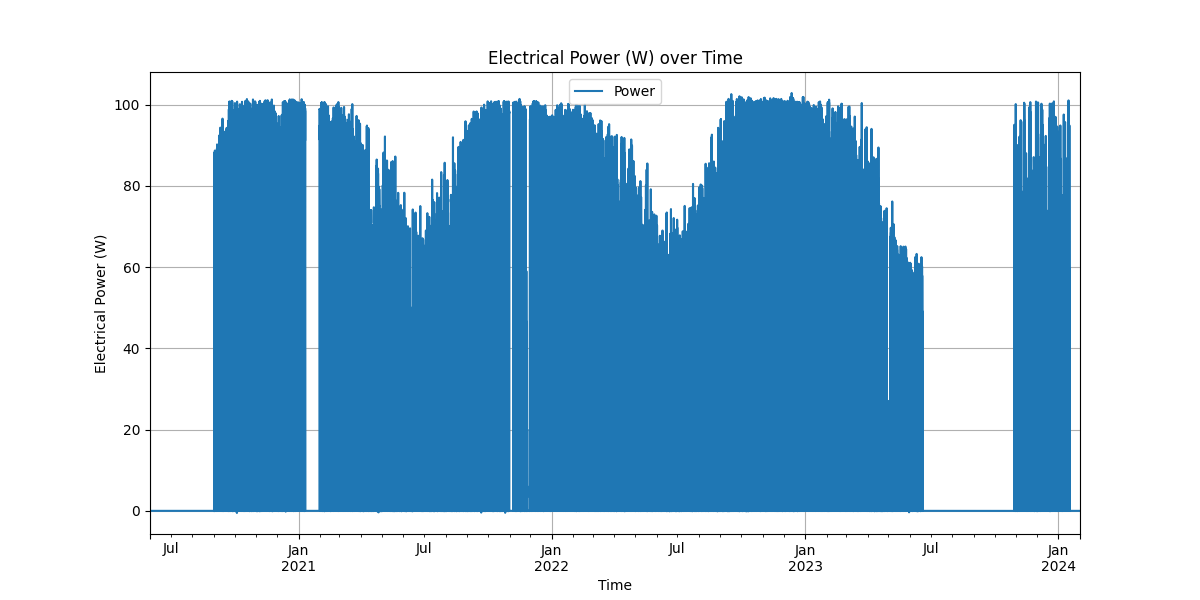

In [20]:
# Load the data from the pickle file
data_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Data\full_site_pow_5min.pkl"
df = pd.read_pickle(data_file)

# print the head
print(df.head())

# downscale to make the power MW
df['Power'] = df['Power']/1e3

# Set the Timestamp as datatime format and index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# plot the data, it only has one column
df.plot(figsize=long_hoz_figsize)
plt.title('Electrical Power (W) over Time')
plt.xlabel('Time')
plt.ylabel('Electrical Power (W)')
plt.grid()
plt.show()


# 3. Weather data visualisation for PVsyst input weather data

Index(['Timestamp', 'Air Humidity (Avg )_median', 'Air Pressure (Avg )_median',
       'Air Temperature mean (Avg )_median',
       'Albedo Irradiance mean (Avg )_median',
       'GHI Irradiance mean (Avg )_median',
       'POA Irradiance mean (Avg )_median', 'Wind Direction (Avg )_median',
       'Wind Speed mean (Avg )_median', 'albedo_ratio_median',
       'albedo_ratio_resampled_median', 'Wind Speed (10m) mean (Avg )_median',
       'Air Temperature mean (Avg )', 'GHI Irradiance mean (Avg )'],
      dtype='object')

=== MISSING DATA ANALYSIS ===
NaN values in Timestamp column: 0
Most common time difference: 0 days 00:05:00
Detected data frequency: 5min
Total expected timestamps: 105120
Actual unique timestamps: 105120
Missing timestamps: 0 (0.00%)

Humidity column found: ['Air Humidity (Avg )_median']
Temperature column found: ['Air Temperature mean (Avg )_median']
GHI column found: ['GHI Irradiance mean (Avg )']
Wind speed column found: ['Wind Speed (10m) mean (Avg )_median']

===

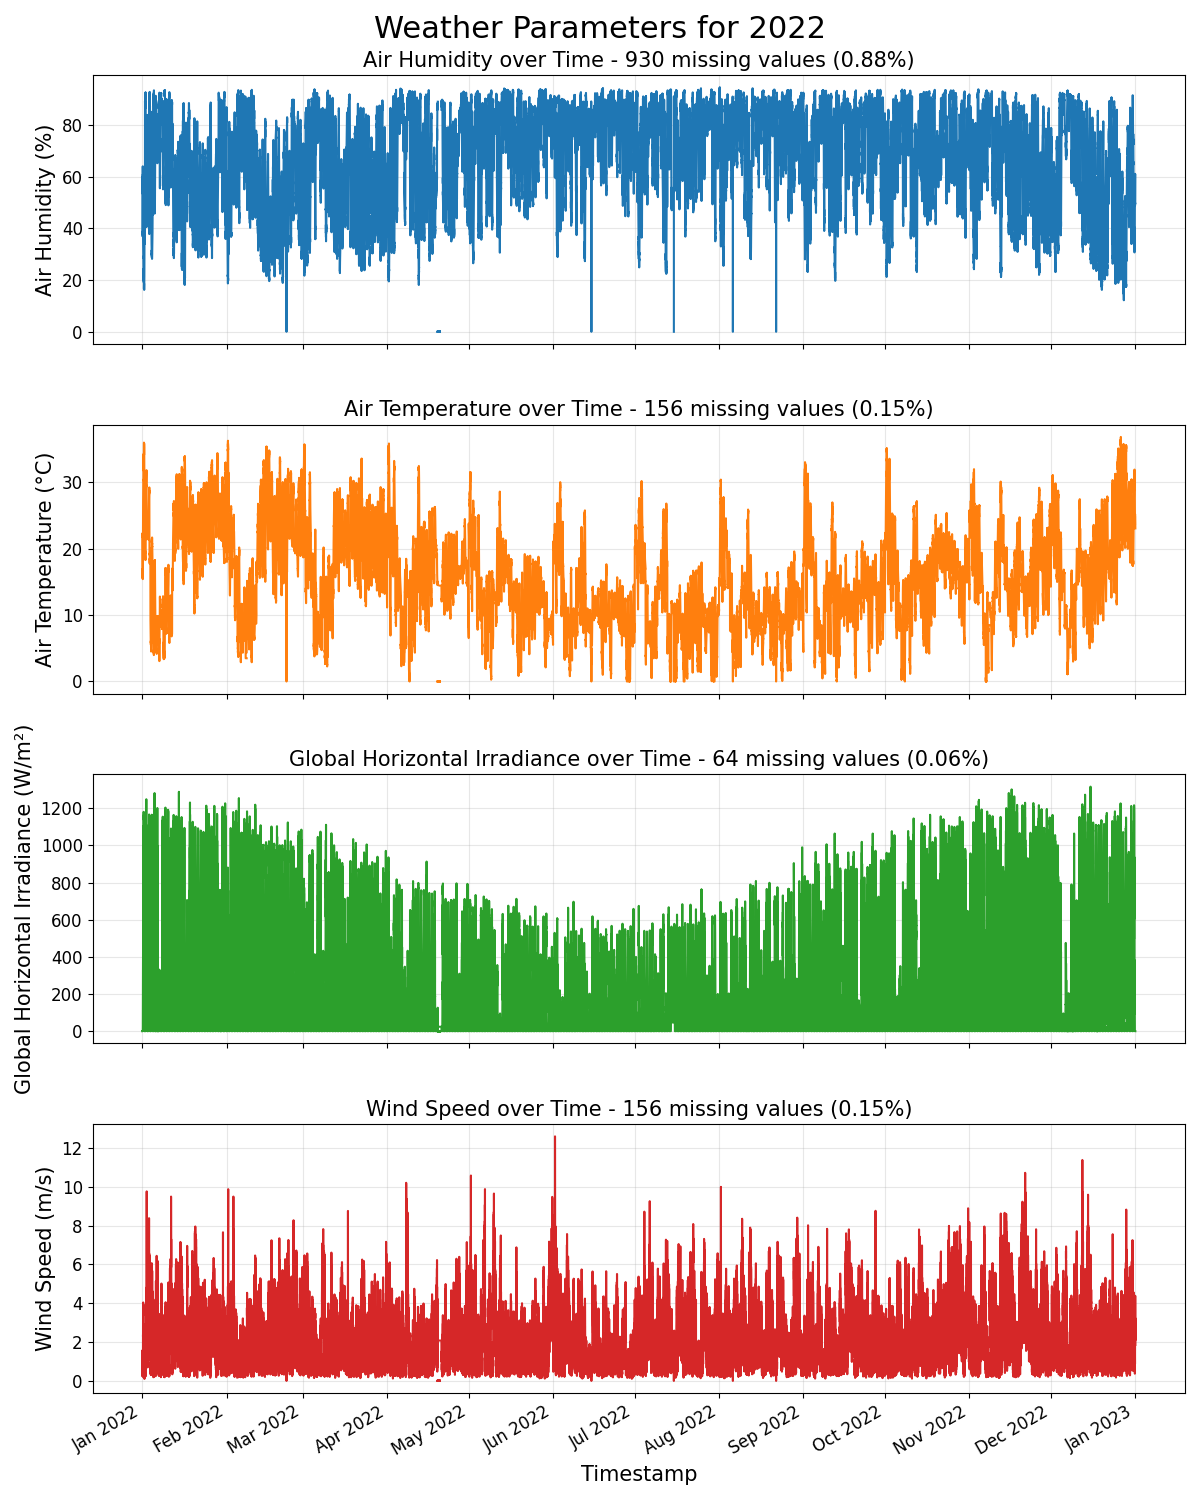

In [21]:
%matplotlib ipympl

# the weather data file directory
PVsyst_weather = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Results\PVsyst_weather_2022.csv"

# read the csv file from the directory
PVsyst_weather_df = pd.read_csv(PVsyst_weather)

# print the columns
print(PVsyst_weather_df.columns)

# ensure the Timestamp column is in datetime format
PVsyst_weather_df['Timestamp'] = pd.to_datetime(PVsyst_weather_df['Timestamp'], errors='coerce')

# Check for missing timestamps
print("\n=== MISSING DATA ANALYSIS ===")

# Check if there are any NaN timestamps
nan_timestamps = PVsyst_weather_df['Timestamp'].isna().sum()
print(f"NaN values in Timestamp column: {nan_timestamps}")

# Calculate the expected time frequency based on the most common time difference
time_diffs = PVsyst_weather_df['Timestamp'].dropna().sort_values().diff().value_counts()
most_common_diff = time_diffs.index[0]
print(f"Most common time difference: {most_common_diff}")

# Create a complete timestamp range based on detected frequency
min_timestamp = PVsyst_weather_df['Timestamp'].min()
max_timestamp = PVsyst_weather_df['Timestamp'].max()
expected_freq = 'H'  # Default to hourly if we can't detect
if most_common_diff <= pd.Timedelta(minutes=10):
    expected_freq = '5min'
elif most_common_diff <= pd.Timedelta(minutes=20):
    expected_freq = '15min'
elif most_common_diff <= pd.Timedelta(minutes=40):
    expected_freq = '30min'
elif most_common_diff <= pd.Timedelta(hours=1.5):
    expected_freq = 'H'
else:
    expected_freq = 'D'

print(f"Detected data frequency: {expected_freq}")
expected_timestamps = pd.date_range(start=min_timestamp, end=max_timestamp, freq=expected_freq)
actual_timestamps = PVsyst_weather_df['Timestamp'].dropna().unique()

missing_timestamps = len(expected_timestamps) - len(actual_timestamps)
print(f"Total expected timestamps: {len(expected_timestamps)}")
print(f"Actual unique timestamps: {len(actual_timestamps)}")
print(f"Missing timestamps: {missing_timestamps} ({missing_timestamps/len(expected_timestamps)*100:.2f}%)")

# Find the columns for each parameter - using specific column names
humidity_col = [col for col in PVsyst_weather_df.columns if 'Air Humidity' in col and 'median' in col]
temperature_col = [col for col in PVsyst_weather_df.columns if 'Air Temperature' in col and 'median' in col]
# Changed to use 'GHI Irradiance mean (Avg )' instead of the median version
ghi_col = ['GHI Irradiance mean (Avg )'] if 'GHI Irradiance mean (Avg )' in PVsyst_weather_df.columns else []
# Specify the exact wind speed column name
wind_speed_col = ['Wind Speed (10m) mean (Avg )_median'] if 'Wind Speed (10m) mean (Avg )_median' in PVsyst_weather_df.columns else []

# Print which columns were found
print(f"\nHumidity column found: {humidity_col}")
print(f"Temperature column found: {temperature_col}")
print(f"GHI column found: {ghi_col}")
print(f"Wind speed column found: {wind_speed_col}")

# Collect found columns or notify if missing
parameters = [
    (humidity_col, 'Air Humidity', '%'),
    (temperature_col, 'Air Temperature', '°C'),
    (ghi_col, 'Global Horizontal Irradiance', 'W/m²'),
    (wind_speed_col, 'Wind Speed', 'm/s')
]

# Count missing values in each parameter column
print("\n=== MISSING VALUES BY PARAMETER ===")
for col_list, param_name, unit in parameters:
    if col_list:
        col = col_list[0]
        missing_count = PVsyst_weather_df[col].isna().sum()
        missing_percent = (missing_count / len(PVsyst_weather_df)) * 100
        print(f"{param_name}: {missing_count} missing values ({missing_percent:.2f}%)")
    else:
        print(f"{param_name}: No column found")

# Create a figure with 4 subplots stacked vertically
fig, axes = plt.subplots(4, 1, figsize=(12, 15), sharex=True)

# Lists to store column names and corresponding labels
columns = []
labels = []
units = []

# Plot each parameter in its own subplot
for i, (col_list, param_name, unit) in enumerate(parameters):
    ax = axes[i]
    
    if col_list:
        col = col_list[0]  # Take the first match
        
        # Count missing values for this parameter
        missing_count = PVsyst_weather_df[col].isna().sum()
        missing_percent = (missing_count / len(PVsyst_weather_df)) * 100
        
        ax.plot(PVsyst_weather_df['Timestamp'], PVsyst_weather_df[col], 
                linewidth=1.5, color=f'C{i}')
        ax.set_ylabel(f'{param_name} ({unit})', fontsize=axis_label_size)
        ax.set_title(f'{param_name} over Time - {missing_count} missing values ({missing_percent:.2f}%)', 
                     fontsize=axis_label_size)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=axis_num_size)
        
        # Print statistics for this parameter
        print(f"\nStatistics for {col}:")
        print(f"Min: {PVsyst_weather_df[col].min():.2f} {unit}")
        print(f"Max: {PVsyst_weather_df[col].max():.2f} {unit}")
        print(f"Mean: {PVsyst_weather_df[col].mean():.2f} {unit}")
        print(f"Median: {PVsyst_weather_df[col].median():.2f} {unit}")
    else:
        ax.text(0.5, 0.5, f"No {param_name} data found", 
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        print(f"No column found for {param_name}")

# Format the shared x-axis
axes[-1].set_xlabel('Timestamp', fontsize=axis_label_size)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
fig.autofmt_xdate()

# Add an overall title
fig.suptitle('Weather Parameters for 2022', fontsize=title_size, y=0.99)

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)

# Show the plot
plt.show()

# 3. Simulation results visualisation

## 3.1. Data loading

In [22]:
# simulation results directory
simulation_results_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Data\25_08_25_Bowen Solar Farm 2022_VCG_HourlyRes_1.CSV"

print(f"Loading PVsyst CSV file: {simulation_results_dir}")

try:
    # Load CSV with better parameters
    # Skip rows 0-9 (metadata), use row 10 as header, skip row 11 (units)
    simulation_results_df = pd.read_csv(
        simulation_results_dir,
        delimiter=';',
        skiprows=list(range(10)) + [11],  # Skip metadata (0-9) and units row (11)
        header=0,  # Row 10 becomes the header after skipping
        encoding='latin-1',  # Keep the encoding that worked
        low_memory=False,
        na_values=['', ' ', 'nan', 'NaN']
    )
    
    print(f"Raw DataFrame loaded with shape: {simulation_results_df.shape}")
    
    # Get the first column (should be date/time)
    date_col = simulation_results_df.columns[0]
    print(f"Found date column: '{date_col}'")
    
    # Print sample of raw date values to debug
    print("Sample raw date values:")
    print(simulation_results_df[date_col].head(10).tolist())
    
    # Parse timestamps - Try multiple formats
    # First attempt the specified format
    simulation_results_df['timestamp'] = pd.to_datetime(
        simulation_results_df[date_col], 
        format='%d/%m/%Y %H:%M',  # Try full year format first
        errors='coerce'
    )
    
    # If we have NaT values, try alternative format with 2-digit year
    if simulation_results_df['timestamp'].isna().any():
        print("Some dates failed to parse. Trying alternative format...")
        simulation_results_df['timestamp'] = pd.to_datetime(
            simulation_results_df[date_col], 
            format='%d/%m/%y %H:%M',  # Try 2-digit year format
            errors='coerce'
        )
    
    # If still problems, try the flexible parser
    if simulation_results_df['timestamp'].isna().any():
        print("Still having parsing issues. Using flexible parser...")
        simulation_results_df['timestamp'] = pd.to_datetime(
            simulation_results_df[date_col],
            dayfirst=True,  # Important for DD/MM/YY format
            errors='coerce'
        )
    
    # Drop the original date column
    simulation_results_df = simulation_results_df.drop(columns=[date_col])
    
    # Basic data cleaning
    # Remove rows where timestamp is null
    initial_rows = len(simulation_results_df)
    simulation_results_df = simulation_results_df.dropna(subset=['timestamp'])
    print(f"Removed {initial_rows - len(simulation_results_df)} rows with invalid timestamps")
    
    # Sort by timestamp to ensure chronological order
    simulation_results_df = simulation_results_df.sort_values('timestamp').reset_index(drop=True)
    
    # Remove duplicate timestamps if any
    duplicates = simulation_results_df.duplicated(subset=['timestamp']).sum()
    if duplicates > 0:
        print(f"Found and removing {duplicates} duplicate timestamps")
        simulation_results_df = simulation_results_df.drop_duplicates(subset=['timestamp'], keep='first')
    
    # Data validation and timestamp analysis
    print("\n=== TIMESTAMP ANALYSIS ===")
    print(f"Total timestamps: {len(simulation_results_df)}")
    print(f"Date range: {simulation_results_df['timestamp'].min()} to {simulation_results_df['timestamp'].max()}")
    
    # Check timestamp continuity
    time_diffs = simulation_results_df['timestamp'].diff()[1:]  # Skip first NaT
    common_diff = time_diffs.value_counts().index[0]
    print(f"Most common time difference: {common_diff}")
    
    irregular_intervals = (time_diffs != common_diff).sum()
    if irregular_intervals > 0:
        print(f"Warning: Found {irregular_intervals} irregular time intervals")
    
    # Check distribution of timestamps by month
    month_counts = simulation_results_df['timestamp'].dt.month.value_counts().sort_index()
    print("\nTimestamps per month:")
    for month, count in month_counts.items():
        print(f"Month {month}: {count} timestamps")
    
    # Check the first and last few days of each month
    print("\nDate ranges by month:")
    for month in sorted(simulation_results_df['timestamp'].dt.month.unique()):
        month_data = simulation_results_df[simulation_results_df['timestamp'].dt.month == month]
        print(f"Month {month}: {month_data['timestamp'].min()} to {month_data['timestamp'].max()}")
        # Get unique days in this month
        days = sorted(month_data['timestamp'].dt.day.unique())
        print(f"  Days: {days[:5]}...{days[-5:] if len(days) > 5 else days}")
    
    # Print the columns
    print("\nColumns:")
    print(simulation_results_df.columns.tolist())
    
    # Check for 'EArray' column
    print(f"Does 'EArray' column exist? {'EArray' in simulation_results_df.columns}")
    
except Exception as e:
    print(f"Error loading PVsyst CSV: {e}")
    raise

Loading PVsyst CSV file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Data\25_08_25_Bowen Solar Farm 2022_VCG_HourlyRes_1.CSV
Raw DataFrame loaded with shape: (8760, 154)
Found date column: 'date'
Sample raw date values:
['01/01/22 00:00', '01/01/22 01:00', '01/01/22 02:00', '01/01/22 03:00', '01/01/22 04:00', '01/01/22 05:00', '01/01/22 06:00', '01/01/22 07:00', '01/01/22 08:00', '01/01/22 09:00']
Some dates failed to parse. Trying alternative format...
Removed 0 rows with invalid timestamps

=== TIMESTAMP ANALYSIS ===
Total timestamps: 8760
Date range: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Most common time difference: 0 days 01:00:00

Timestamps per month:
Month 1: 744 timestamps
Month 2: 672 timestamps
Month 3: 744 timestamps
Month 4: 720 timestamps
Month 5: 744 timestamps
Month 6: 720 timestamps
Month 7: 744 timestamps
Month 8: 744 timestamps
Month 9: 720 timestamps
Month 10: 744 timestamps
Month 11: 720 timestamps
Month 12: 744 timestamps

D

## 3.2. Visualisation

### 3.2.1. Hourly raw data

EArray column is already numeric type: float64
Set timestamp as index
No clipping applied to EArray values
Resampled actual power from 385920 5-minute intervals to 32160 hourly averages
EArray Min: 0.00 MW
EArray Max: 118.16 MW
EArray Mean: 20.67 MW
Total simulation data points: 8760

Actual Power Min: -0.04 MW
Actual Power Max: 101.03 MW
Actual Power Mean: 19.30 MW
Total actual data points: 32160


C:\Users\z5183876\AppData\Local\Temp\ipykernel_43616\3849577127.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_actual_power = df['Power'].resample('H').mean()


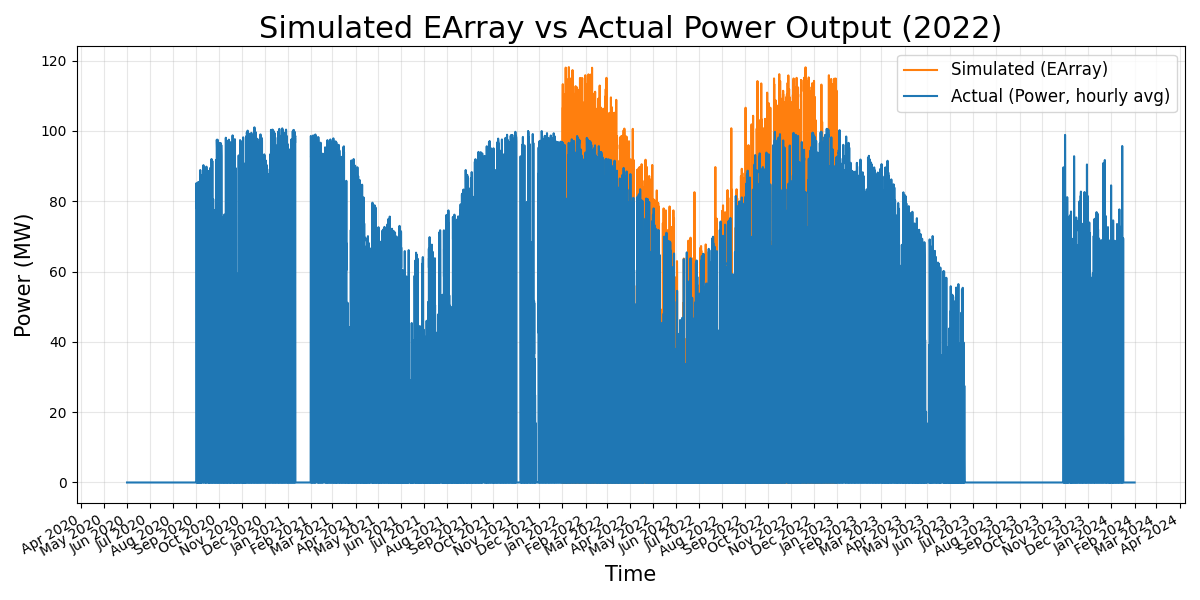

In [23]:
# Define clipping options at the beginning
apply_clipping = False  # Set to False to disable clipping
clipping_threshold = 100  # Clipping threshold in MW

# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Apply clipping to the simulated power if enabled
if apply_clipping:
    simulation_results_df['EArray_display'] = simulation_results_df['EArray'].clip(upper=clipping_threshold)
    print(f"Applied {clipping_threshold} MW clipping to EArray values: {(simulation_results_df['EArray'] > clipping_threshold).sum()} values clipped")
    earray_label = f'Simulated (EArray, clipped at {clipping_threshold} MW)'
else:
    simulation_results_df['EArray_display'] = simulation_results_df['EArray']
    print("No clipping applied to EArray values")
    earray_label = 'Simulated (EArray)'

# Resample the actual power data to hourly averages
hourly_actual_power = df['Power'].resample('H').mean()
print(f"Resampled actual power from {len(df)} 5-minute intervals to {len(hourly_actual_power)} hourly averages")

# Create a figure for both datasets
plt.figure(figsize=long_hoz_figsize)

# Plot simulation EArray data (with or without clipping)
plt.plot(simulation_results_df.index, simulation_results_df['EArray_display'], 
         linewidth=1.5, color='#ff7f0e', label=earray_label)

# Plot actual power data (hourly resampled)
plt.plot(hourly_actual_power.index, hourly_actual_power, 
         linewidth=1.5, color='#1f77b4', label='Actual (Power, hourly avg)')

# Add labels and title
plt.xlabel('Time', fontsize=axis_label_size)
plt.ylabel('Power (MW)', fontsize=axis_label_size)
title_suffix = " (clipped)" if apply_clipping else ""
plt.title(f'Simulated EArray vs Actual Power Output (2022){title_suffix}', fontsize=title_size)

# Add legend
plt.legend(fontsize=text_size)

# Add grid
plt.grid(True, alpha=0.3)

# Format the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout
plt.tight_layout()

# Print some statistics
print(f"EArray Min: {simulation_results_df['EArray_display'].min():.2f} MW")
print(f"EArray Max: {simulation_results_df['EArray_display'].max():.2f} MW")
print(f"EArray Mean: {simulation_results_df['EArray_display'].mean():.2f} MW")
print(f"Total simulation data points: {len(simulation_results_df)}")

print(f"\nActual Power Min: {hourly_actual_power.min():.2f} MW")
print(f"Actual Power Max: {hourly_actual_power.max():.2f} MW")
print(f"Actual Power Mean: {hourly_actual_power.mean():.2f} MW")
print(f"Total actual data points: {len(hourly_actual_power)}")

# Show plot
plt.show()

### 3.2.2. Hourly filtered & scaled

EArray column is already numeric type: float64
Resampled actual power from 385920 5-minute intervals to 32160 hourly averages
After filtering for matching timestamps: 8760 data points
Loaded 275 maintenance-free days
After filtering for maintenance-free days: 6600 data points

=== FINDING OPTIMAL SCALE FACTOR ===
Iteration 1: Factor range [0.500000, 1.250000, 2.000000], MBE: [-13.172692, 3.681249, 20.535191]
Iteration 2: Factor range [0.500000, 0.875000, 1.250000], MBE: [-13.172692, -4.745721, 3.681249]
Iteration 3: Factor range [0.875000, 1.062500, 1.250000], MBE: [-4.745721, -0.532236, 3.681249]
Iteration 4: Factor range [1.062500, 1.156250, 1.250000], MBE: [-0.532236, 1.574507, 3.681249]
Iteration 5: Factor range [1.062500, 1.109375, 1.156250], MBE: [-0.532236, 0.521135, 1.574507]
Iteration 6: Factor range [1.062500, 1.085938, 1.109375], MBE: [-0.532236, -0.005550, 0.521135]
Iteration 7: Factor range [1.085938, 1.097656, 1.109375], MBE: [-0.005550, 0.257793, 0.521135]
Iteration 8: F

C:\Users\z5183876\AppData\Local\Temp\ipykernel_43616\2041586825.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_actual_power = df['Power'].resample('H').mean()
C:\Users\z5183876\AppData\Local\Temp\ipykernel_43616\2041586825.py:205: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


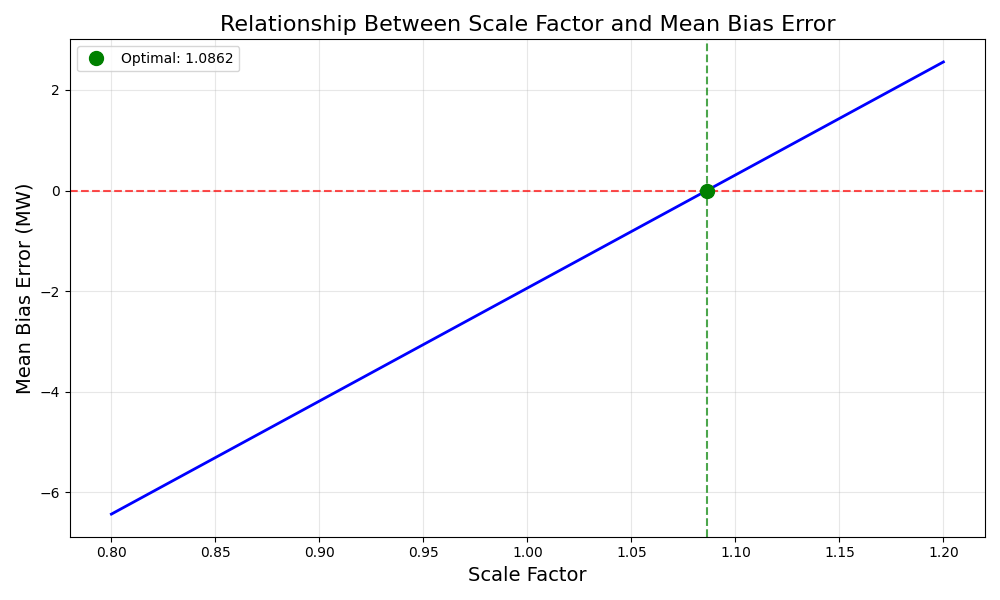


Recommendation: Use a scale factor of 1.0862 for zero bias.


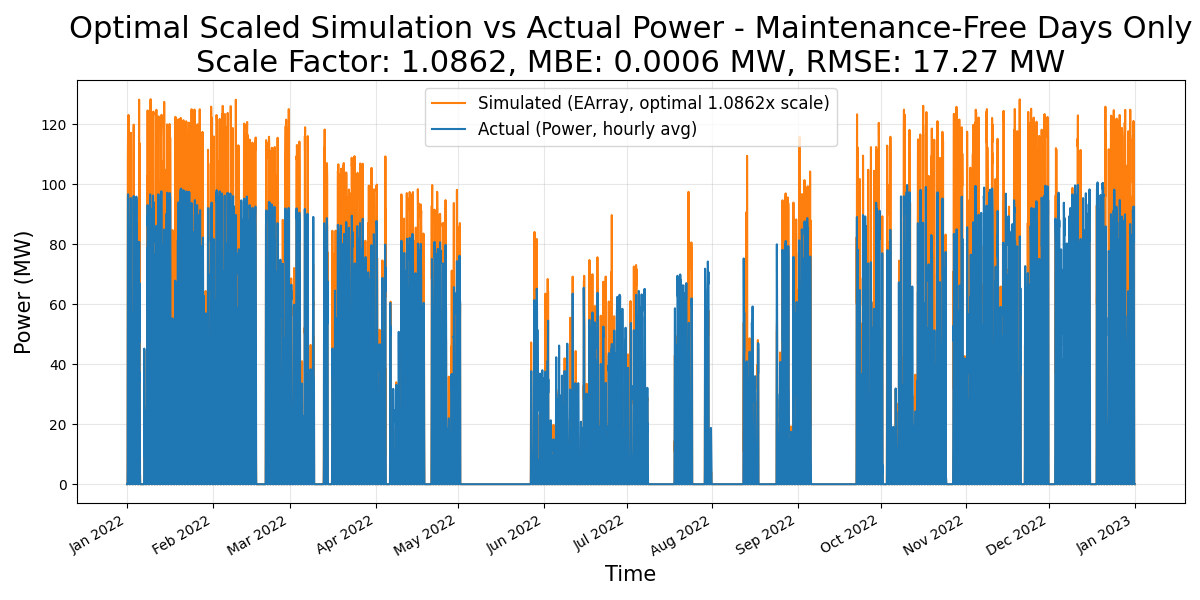

In [24]:
# Define function to calculate MBE for a given scale factor
def calculate_mbe(scale_factor, original_sim_data, actual_data, apply_clipping=False, clipping_threshold=100):
    """
    Calculate Mean Bias Error for a given scale factor.
    
    Parameters:
    -----------
    scale_factor : float
        Scale factor to apply to simulated data
    original_sim_data : Series
        Original simulated power data
    actual_data : Series
        Actual power data
    apply_clipping : bool
        Whether to apply clipping to scaled simulated data
    clipping_threshold : float
        Threshold for clipping in MW
        
    Returns:
    --------
    mbe : float
        Mean Bias Error
    """
    # Scale the simulated data
    scaled_sim_data = original_sim_data * scale_factor
    
    # Apply clipping if requested
    if apply_clipping:
        scaled_sim_data = scaled_sim_data.clip(upper=clipping_threshold)
    
    # Calculate MBE
    mbe = np.mean(scaled_sim_data - actual_data)
    
    return mbe

# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Resample the actual power data to hourly averages
hourly_actual_power = df['Power'].resample('H').mean()
print(f"Resampled actual power from {len(df)} 5-minute intervals to {len(hourly_actual_power)} hourly averages")

# 1. Create a combined DataFrame with both actual and simulated power
combined_df = pd.DataFrame()
combined_df['Actual'] = hourly_actual_power
combined_df['Simulated'] = simulation_results_df['EArray']

# Filter to include only timestamps where both actual and simulated power exist
combined_df = combined_df.dropna()
print(f"After filtering for matching timestamps: {len(combined_df)} data points")

# 2. Load the maintenance-free days from the text file
maintenance_free_days_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Results\maintenance_free_days_2022.txt"
try:
    with open(maintenance_free_days_file, 'r') as f:
        maintenance_free_days = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"Loaded {len(maintenance_free_days)} maintenance-free days")
    
    # Convert maintenance-free days to datetime for filtering
    maintenance_free_dates = pd.to_datetime(maintenance_free_days)
    
    # Filter the combined dataframe to only include maintenance-free days
    combined_df['date'] = combined_df.index.date
    filtered_df = combined_df[combined_df['date'].isin([date.date() for date in maintenance_free_dates])]
    
    print(f"After filtering for maintenance-free days: {len(filtered_df)} data points")
    
except Exception as e:
    print(f"Error loading maintenance-free days: {e}")
    # If there's an error, continue with the unfiltered data
    filtered_df = combined_df
    print("Continuing with all available data points")

# 3. Find optimal scale factor to make MBE = 0
print("\n=== FINDING OPTIMAL SCALE FACTOR ===")

# Define clipping settings
apply_clipping = False  # Set to True to enable clipping during optimization
clipping_threshold = 100  # Clipping threshold in MW

# Use binary search to find scale factor that gives MBE closest to zero
def binary_search_optimal_factor(min_factor=0.5, max_factor=2.0, tolerance=0.0001):
    """
    Binary search to find the scale factor that makes MBE closest to zero.
    
    Parameters:
    -----------
    min_factor : float
        Minimum scale factor to consider
    max_factor : float
        Maximum scale factor to consider
    tolerance : float
        Tolerance for MBE, stop when abs(MBE) < tolerance
        
    Returns:
    --------
    optimal_factor : float
        Scale factor that gives MBE closest to zero
    iterations : int
        Number of iterations performed
    """
    iterations = 0
    max_iterations = 100  # Avoid infinite loops
    
    while iterations < max_iterations:
        iterations += 1
        mid_factor = (min_factor + max_factor) / 2
        
        mbe_min = calculate_mbe(min_factor, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold)
        mbe_mid = calculate_mbe(mid_factor, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold)
        mbe_max = calculate_mbe(max_factor, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold)
        
        print(f"Iteration {iterations}: Factor range [{min_factor:.6f}, {mid_factor:.6f}, {max_factor:.6f}], MBE: [{mbe_min:.6f}, {mbe_mid:.6f}, {mbe_max:.6f}]")
        
        # If MBE is close enough to zero, we found our answer
        if abs(mbe_mid) < tolerance:
            return mid_factor, iterations
        
        # Adjust the search range based on MBE sign
        if mbe_min * mbe_mid <= 0:  # Opposite signs or one is zero
            max_factor = mid_factor
        else:
            min_factor = mid_factor
        
        # If the range gets too small, stop
        if max_factor - min_factor < tolerance:
            return mid_factor, iterations
    
    # If we reach max iterations, return the best we have
    return (min_factor + max_factor) / 2, iterations

# Execute binary search
optimal_scale_factor, iterations = binary_search_optimal_factor()

# Apply the optimal scale factor and calculate metrics
scaled_sim_data = filtered_df['Simulated'] * optimal_scale_factor
if apply_clipping:
    scaled_sim_data = scaled_sim_data.clip(upper=clipping_threshold)

# Calculate error metrics with optimal scale factor
final_mbe = np.mean(scaled_sim_data - filtered_df['Actual'])
final_rmse = np.sqrt(np.mean((filtered_df['Actual'] - scaled_sim_data)**2))
actual_centered = filtered_df['Actual'] - filtered_df['Actual'].mean()
simulated_centered = scaled_sim_data - scaled_sim_data.mean()
final_crmse = np.sqrt(np.mean((actual_centered - simulated_centered)**2))

print("\n=== OPTIMIZATION RESULTS ===")
print(f"Optimal scale factor: {optimal_scale_factor:.6f}")
print(f"Found in {iterations} iterations")
print(f"Final MBE: {final_mbe:.6f} MW")
print(f"Final RMSE: {final_rmse:.2f} MW")
print(f"Final CRMSE: {final_crmse:.2f} MW")

# 4. Visualize the result
plt.figure(figsize=long_hoz_figsize)

# Plot optimally scaled simulation data
plt.plot(filtered_df.index, scaled_sim_data, 
         linewidth=1.5, color='#ff7f0e', label=f'Simulated (EArray, optimal {optimal_scale_factor:.4f}x scale)')

# Plot filtered actual power data
plt.plot(filtered_df.index, filtered_df['Actual'], 
         linewidth=1.5, color='#1f77b4', label='Actual (Power, hourly avg)')

# Add labels and title
plt.xlabel('Time', fontsize=axis_label_size)
plt.ylabel('Power (MW)', fontsize=axis_label_size)
clip_suffix = " (clipped)" if apply_clipping else ""
plt.title(f'Optimal Scaled Simulation vs Actual Power - Maintenance-Free Days Only{clip_suffix}\n'
          f'Scale Factor: {optimal_scale_factor:.4f}, MBE: {final_mbe:.4f} MW, RMSE: {final_rmse:.2f} MW', 
          fontsize=title_size)

# Add legend
plt.legend(fontsize=text_size)

# Add grid
plt.grid(True, alpha=0.3)

# Format the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout
plt.tight_layout()

# Create a second plot to show the relationship between scale factor and MBE
plt.figure(figsize=(10, 6))

# Generate a range of scale factors and their corresponding MBE values
scale_factors = np.linspace(0.8, 1.2, 100)
mbe_values = [calculate_mbe(sf, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold) 
              for sf in scale_factors]

# Plot the relationship
plt.plot(scale_factors, mbe_values, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)  # Zero MBE line
plt.axvline(x=optimal_scale_factor, color='g', linestyle='--', alpha=0.7)  # Optimal scale factor line

# Add markers for important points
plt.plot(optimal_scale_factor, final_mbe, 'go', markersize=10, label=f'Optimal: {optimal_scale_factor:.4f}')

# Add labels and title
plt.xlabel('Scale Factor', fontsize=14)
plt.ylabel('Mean Bias Error (MW)', fontsize=14)
plt.title('Relationship Between Scale Factor and Mean Bias Error', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

print("\nRecommendation: Use a scale factor of {:.4f} for zero bias.".format(optimal_scale_factor))

EArray column is already numeric type: float64
No clipping applied to EArray values
Resampled actual power from 385920 5-minute intervals to 32160 hourly averages
After filtering for matching timestamps: 8760 data points
Loaded 275 maintenance-free days
After filtering for maintenance-free days: 6600 data points

=== ERROR METRICS ===
RMSE: 17.27 MW
CRMSE: 17.27 MW
MBE: 0.00 MW

=== FILTERED DATA STATISTICS ===
Filtered Actual Power Min: -0.01 MW
Filtered Actual Power Max: 100.60 MW
Filtered Actual Power Mean: 24.41 MW
Filtered Simulated Power Min: 0.00 MW
Filtered Simulated Power Max: 128.35 MW
Filtered Simulated Power Mean: 24.41 MW


C:\Users\z5183876\AppData\Local\Temp\ipykernel_43616\3358336812.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_actual_power = df['Power'].resample('H').mean()


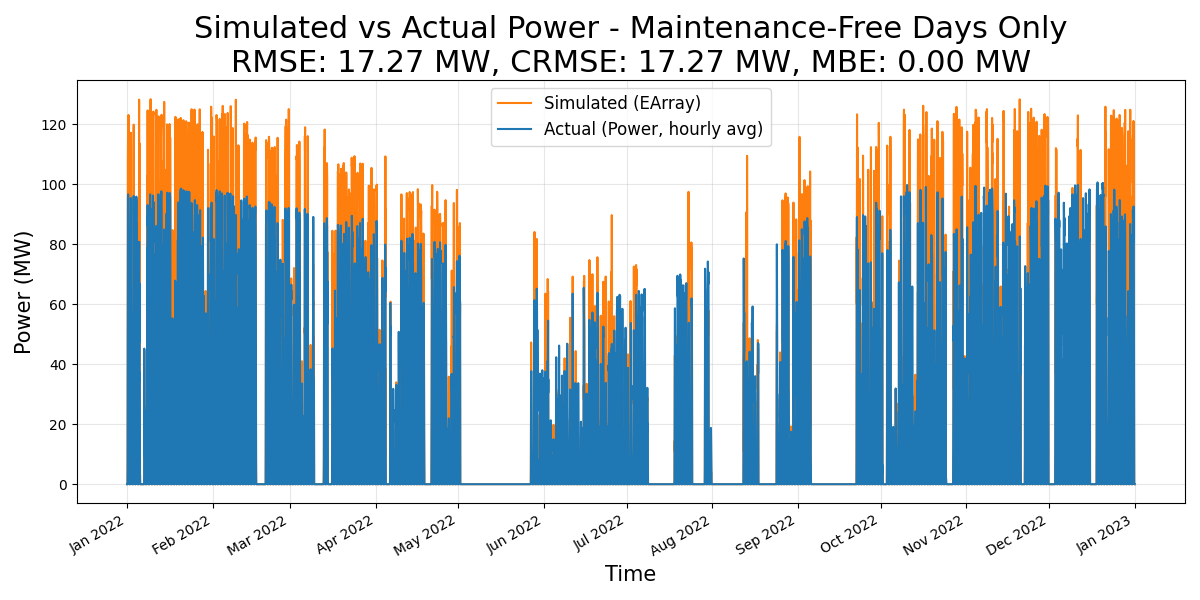

In [26]:
# Define clipping options at the beginning
apply_clipping = False  # Set to True to enable clipping
clipping_threshold = 100  # Clipping threshold in MW
hourly_PVsyst_scale_factor = optimal_scale_factor
# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Apply clipping to the simulated power if enabled
if apply_clipping:
    simulation_results_df['EArray_display'] = (hourly_actual_power*simulation_results_df['EArray']).clip(upper=clipping_threshold)
    print(f"Applied {clipping_threshold} MW clipping to EArray values: {(simulation_results_df['EArray'] > clipping_threshold).sum()} values clipped")
    earray_label = f'Simulated (EArray, clipped at {clipping_threshold} MW)'
else:
    simulation_results_df['EArray_display'] = simulation_results_df['EArray']*hourly_PVsyst_scale_factor
    print("No clipping applied to EArray values")
    earray_label = 'Simulated (EArray)'

# Resample the actual power data to hourly averages
hourly_actual_power = df['Power'].resample('H').mean()
print(f"Resampled actual power from {len(df)} 5-minute intervals to {len(hourly_actual_power)} hourly averages")

# 1. Create a combined DataFrame with both actual and simulated power
combined_df = pd.DataFrame()
combined_df['Actual'] = hourly_actual_power
combined_df['Simulated'] = simulation_results_df['EArray_display']

# Filter to include only timestamps where both actual and simulated power exist
combined_df = combined_df.dropna()
print(f"After filtering for matching timestamps: {len(combined_df)} data points")

# 2. Load the maintenance-free days from the text file
maintenance_free_days_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Results\maintenance_free_days_2022.txt"
try:
    with open(maintenance_free_days_file, 'r') as f:
        maintenance_free_days = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"Loaded {len(maintenance_free_days)} maintenance-free days")
    
    # Convert maintenance-free days to datetime for filtering
    maintenance_free_dates = pd.to_datetime(maintenance_free_days)
    
    # Filter the combined dataframe to only include maintenance-free days
    combined_df['date'] = combined_df.index.date
    filtered_df = combined_df[combined_df['date'].isin([date.date() for date in maintenance_free_dates])]
    
    print(f"After filtering for maintenance-free days: {len(filtered_df)} data points")
    
except Exception as e:
    print(f"Error loading maintenance-free days: {e}")
    # If there's an error, continue with the unfiltered data
    filtered_df = combined_df
    print("Continuing with all available data points")

# 3. Calculate error metrics
# RMSE (Root Mean Square Error)
rmse = np.sqrt(np.mean((filtered_df['Actual'] - filtered_df['Simulated'])**2))

# CRMSE (Centralized RMSE)
actual_centered = filtered_df['Actual'] - filtered_df['Actual'].mean()
simulated_centered = filtered_df['Simulated'] - filtered_df['Simulated'].mean()
crmse = np.sqrt(np.mean((actual_centered - simulated_centered)**2))

# MBE (Mean Bias Error)
mbe = np.mean(filtered_df['Simulated'] - filtered_df['Actual'])

# Print error metrics
print("\n=== ERROR METRICS ===")
print(f"RMSE: {rmse:.2f} MW")
print(f"CRMSE: {crmse:.2f} MW")
print(f"MBE: {mbe:.2f} MW")

# Create a figure for the filtered datasets
plt.figure(figsize=long_hoz_figsize)

# Plot filtered simulation data
plt.plot(filtered_df.index, filtered_df['Simulated'], 
         linewidth=1.5, color='#ff7f0e', label=earray_label)

# Plot filtered actual power data
plt.plot(filtered_df.index, filtered_df['Actual'], 
         linewidth=1.5, color='#1f77b4', label='Actual (Power, hourly avg)')

# Add labels and title
plt.xlabel('Time', fontsize=axis_label_size)
plt.ylabel('Power (MW)', fontsize=axis_label_size)
title_suffix = " (clipped)" if apply_clipping else ""
plt.title(f'Simulated vs Actual Power - Maintenance-Free Days Only{title_suffix}\nRMSE: {rmse:.2f} MW, CRMSE: {crmse:.2f} MW, MBE: {mbe:.2f} MW', 
          fontsize=title_size)

# Add legend
plt.legend(fontsize=text_size)

# Add grid
plt.grid(True, alpha=0.3)

# Format the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout
plt.tight_layout()

# Print some statistics for the filtered data
print(f"\n=== FILTERED DATA STATISTICS ===")
print(f"Filtered Actual Power Min: {filtered_df['Actual'].min():.2f} MW")
print(f"Filtered Actual Power Max: {filtered_df['Actual'].max():.2f} MW")
print(f"Filtered Actual Power Mean: {filtered_df['Actual'].mean():.2f} MW")

print(f"Filtered Simulated Power Min: {filtered_df['Simulated'].min():.2f} MW")
print(f"Filtered Simulated Power Max: {filtered_df['Simulated'].max():.2f} MW")
print(f"Filtered Simulated Power Mean: {filtered_df['Simulated'].mean():.2f} MW")

# Show plot
plt.show()

### 3.2.2. Daily filtered & scaled

EArray column is already numeric type: float64
Calculated daily energy from 385920 5-minute intervals to 1340 daily totals
Calculated daily energy from 8760 hourly intervals to 365 daily totals
After filtering for matching timestamps: 365 data points
Loaded 275 maintenance-free days
After filtering for maintenance-free days: 275 data points

=== FINDING OPTIMAL SCALE FACTOR ===
Iteration 1: Factor range [0.50000000, 1.25000000, 2.00000000], MBE: [-316.14460939, 88.34998742, 492.84458424]
Iteration 2: Factor range [0.50000000, 0.87500000, 1.25000000], MBE: [-316.14460939, -113.89731098, 88.34998742]
Iteration 3: Factor range [0.87500000, 1.06250000, 1.25000000], MBE: [-113.89731098, -12.77366178, 88.34998742]
Iteration 4: Factor range [1.06250000, 1.15625000, 1.25000000], MBE: [-12.77366178, 37.78816282, 88.34998742]
Iteration 5: Factor range [1.06250000, 1.10937500, 1.15625000], MBE: [-12.77366178, 12.50725052, 37.78816282]
Iteration 6: Factor range [1.06250000, 1.08593750, 1.10937500]

C:\Users\z5183876\AppData\Local\Temp\ipykernel_43616\4204571565.py:291: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


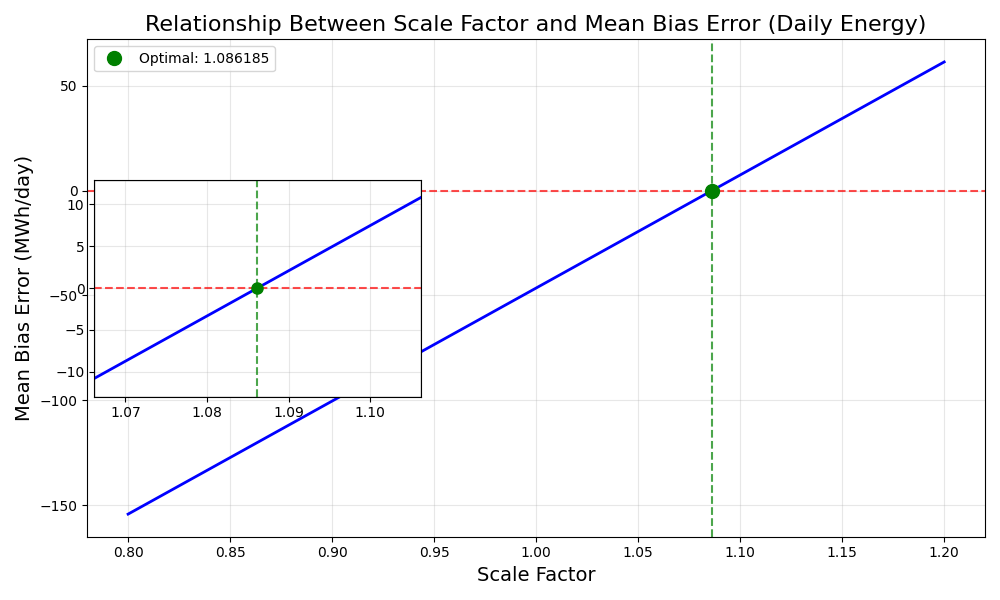


Recommendation: Use a scale factor of 1.086185 for zero bias on daily energy data.


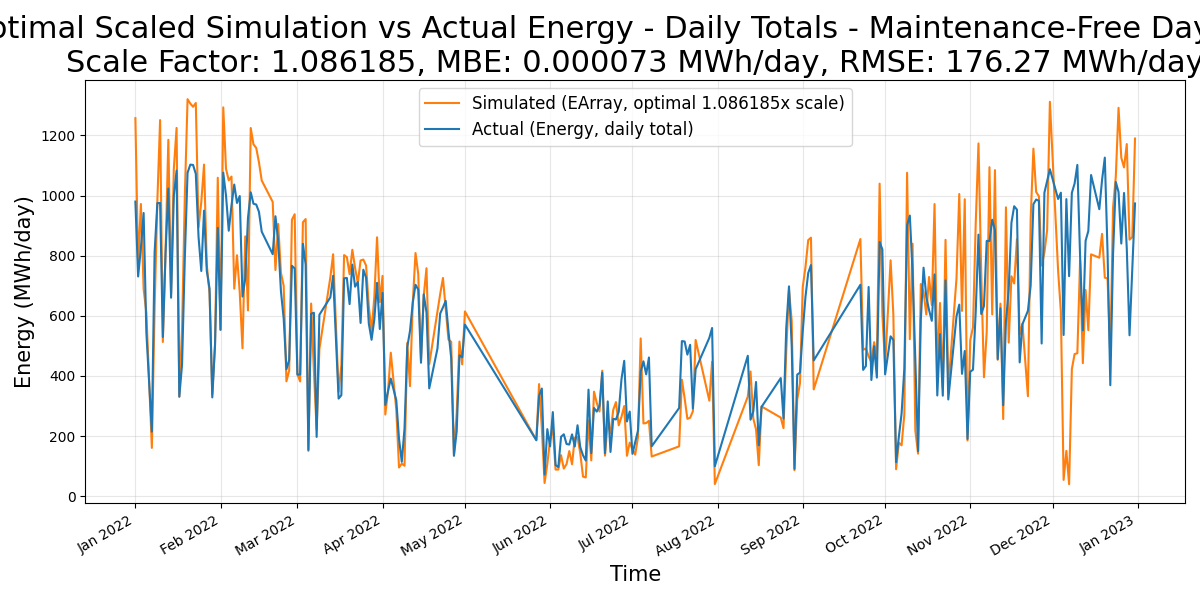

In [29]:
# Define function to calculate MBE for a given scale factor
def calculate_mbe(scale_factor, original_sim_data, actual_data, apply_clipping=False, clipping_threshold=2400):
    """
    Calculate Mean Bias Error for a given scale factor.
    
    Parameters:
    -----------
    scale_factor : float
        Scale factor to apply to simulated data
    original_sim_data : Series
        Original simulated energy data
    actual_data : Series
        Actual energy data
    apply_clipping : bool
        Whether to apply clipping to scaled simulated data
    clipping_threshold : float
        Threshold for clipping in MWh/day
        
    Returns:
    --------
    mbe : float
        Mean Bias Error
    """
    # Scale the simulated data
    scaled_sim_data = original_sim_data * scale_factor
    
    # Apply clipping if requested
    if apply_clipping:
        scaled_sim_data = scaled_sim_data.clip(upper=clipping_threshold)
    
    # Calculate MBE
    mbe = np.mean(scaled_sim_data - actual_data)
    
    return mbe

# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Calculate energy from power data
# For 5-minute actual data, convert MW to MWh (MW * 5/60 hours)
df['Energy_MWh'] = df['Power'] * (5/60)
# For hourly simulation data, convert MW to MWh (MW * 1 hour)
simulation_results_df['Energy_MWh'] = simulation_results_df['EArray']

# Resample to get daily energy totals (MWh/day)
daily_actual_energy = df['Energy_MWh'].resample('D').sum()
print(f"Calculated daily energy from {len(df)} 5-minute intervals to {len(daily_actual_energy)} daily totals")

# Resample simulation data to daily energy totals
daily_simulation_energy = simulation_results_df['Energy_MWh'].resample('D').sum()
print(f"Calculated daily energy from {len(simulation_results_df)} hourly intervals to {len(daily_simulation_energy)} daily totals")

# 1. Create a combined DataFrame with both actual and simulated energy
combined_df = pd.DataFrame()
combined_df['Actual'] = daily_actual_energy
combined_df['Simulated'] = daily_simulation_energy

# Filter to include only timestamps where both actual and simulated energy exist
combined_df = combined_df.dropna()
print(f"After filtering for matching timestamps: {len(combined_df)} data points")

# 2. Load the maintenance-free days from the text file
maintenance_free_days_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Results\maintenance_free_days_2022.txt"
try:
    with open(maintenance_free_days_file, 'r') as f:
        maintenance_free_days = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"Loaded {len(maintenance_free_days)} maintenance-free days")
    
    # Convert maintenance-free days to datetime for filtering
    maintenance_free_dates = pd.to_datetime(maintenance_free_days)
    
    # Filter the combined dataframe to only include maintenance-free days
    combined_df['date'] = combined_df.index.date
    filtered_df = combined_df[combined_df['date'].isin([date.date() for date in maintenance_free_dates])]
    
    print(f"After filtering for maintenance-free days: {len(filtered_df)} data points")
    
except Exception as e:
    print(f"Error loading maintenance-free days: {e}")
    # If there's an error, continue with the unfiltered data
    filtered_df = combined_df
    print("Continuing with all available data points")

# 3. Find optimal scale factor to make MBE = 0
print("\n=== FINDING OPTIMAL SCALE FACTOR ===")

# Define clipping settings - increased for daily energy values
apply_clipping = False  # Set to True to enable clipping during optimization
clipping_threshold = 2400  # Clipping threshold in MWh/day (100MW * 24h = 2400MWh)

# Use binary search to find scale factor that gives MBE closest to zero
def binary_search_optimal_factor(min_factor=0.5, max_factor=2.0, target_tolerance=0.0001, max_iterations=200):
    """
    Binary search to find the scale factor that makes MBE closest to zero.
    
    Parameters:
    -----------
    min_factor : float
        Minimum scale factor to consider
    max_factor : float
        Maximum scale factor to consider
    target_tolerance : float
        Target tolerance for MBE, stop when abs(MBE) < target_tolerance
    max_iterations : int
        Maximum number of iterations to perform
        
    Returns:
    --------
    optimal_factor : float
        Scale factor that gives MBE closest to zero
    iterations : int
        Number of iterations performed
    final_mbe : float
        The final MBE value achieved
    """
    iterations = 0
    best_factor = None
    best_mbe = float('inf')
    
    while iterations < max_iterations:
        iterations += 1
        mid_factor = (min_factor + max_factor) / 2
        
        mbe_min = calculate_mbe(min_factor, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold)
        mbe_mid = calculate_mbe(mid_factor, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold)
        mbe_max = calculate_mbe(max_factor, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold)
        
        # Track the best factor found so far
        if abs(mbe_mid) < abs(best_mbe):
            best_factor = mid_factor
            best_mbe = mbe_mid
        
        print(f"Iteration {iterations}: Factor range [{min_factor:.8f}, {mid_factor:.8f}, {max_factor:.8f}], MBE: [{mbe_min:.8f}, {mbe_mid:.8f}, {mbe_max:.8f}]")
        
        # If MBE is close enough to zero, we found our answer
        if abs(mbe_mid) < target_tolerance:
            print(f"Convergence achieved! MBE = {mbe_mid:.8f} < {target_tolerance}")
            return mid_factor, iterations, mbe_mid
        
        # Adjust the search range based on MBE sign
        if mbe_min * mbe_mid <= 0:  # Opposite signs or one is zero
            max_factor = mid_factor
        else:
            min_factor = mid_factor
        
        # If the range gets too small, we've reached numerical precision limits
        if max_factor - min_factor < 1e-10:
            print(f"Reached numerical precision limit. Best MBE: {mbe_mid:.8f}")
            return mid_factor, iterations, mbe_mid
    
    # If we reach max iterations, return the best we have
    print(f"Reached maximum iterations ({max_iterations}). Best MBE: {best_mbe:.8f}")
    return best_factor, iterations, best_mbe

# Execute binary search with tighter tolerance
optimal_scale_factor, iterations, final_mbe = binary_search_optimal_factor(target_tolerance=0.0001)

# Apply the optimal scale factor and calculate metrics
scaled_sim_data = filtered_df['Simulated'] * optimal_scale_factor
if apply_clipping:
    scaled_sim_data = scaled_sim_data.clip(upper=clipping_threshold)

# Calculate error metrics with optimal scale factor
final_rmse = np.sqrt(np.mean((filtered_df['Actual'] - scaled_sim_data)**2))
actual_centered = filtered_df['Actual'] - filtered_df['Actual'].mean()
simulated_centered = scaled_sim_data - scaled_sim_data.mean()
final_crmse = np.sqrt(np.mean((actual_centered - simulated_centered)**2))

print("\n=== OPTIMIZATION RESULTS ===")
print(f"Optimal scale factor: {optimal_scale_factor:.8f}")
print(f"Found in {iterations} iterations")
print(f"Final MBE: {final_mbe:.8f} MWh/day")
print(f"Final RMSE: {final_rmse:.2f} MWh/day")
print(f"Final CRMSE: {final_crmse:.2f} MWh/day")

# Check if the target MBE tolerance was achieved
if abs(final_mbe) < 0.0001:
    print(f"✓ SUCCESS: Final MBE ({abs(final_mbe):.8f}) is less than 0.0001")
else:
    print(f"⚠ WARNING: Final MBE ({abs(final_mbe):.8f}) is greater than 0.0001")
    print("Consider running with more iterations or adjusting the search range.")

# 4. Visualize the result
plt.figure(figsize=long_hoz_figsize)

# Plot optimally scaled simulation data
plt.plot(filtered_df.index, scaled_sim_data, 
         linewidth=1.5, color='#ff7f0e', label=f'Simulated (EArray, optimal {optimal_scale_factor:.6f}x scale)')

# Plot filtered actual power data
plt.plot(filtered_df.index, filtered_df['Actual'], 
         linewidth=1.5, color='#1f77b4', label='Actual (Energy, daily total)')

# Add labels and title
plt.xlabel('Time', fontsize=axis_label_size)
plt.ylabel('Energy (MWh/day)', fontsize=axis_label_size)
clip_suffix = " (clipped)" if apply_clipping else ""
plt.title(f'Optimal Scaled Simulation vs Actual Energy - Daily Totals - Maintenance-Free Days Only{clip_suffix}\n'
          f'Scale Factor: {optimal_scale_factor:.6f}, MBE: {final_mbe:.6f} MWh/day, RMSE: {final_rmse:.2f} MWh/day', 
          fontsize=title_size)

# Add legend
plt.legend(fontsize=text_size)

# Add grid
plt.grid(True, alpha=0.3)

# Format the date on x-axis - adjust for daily data
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout
plt.tight_layout()

# Create a second plot to show the relationship between scale factor and MBE
plt.figure(figsize=(10, 6))

# Generate a range of scale factors and their corresponding MBE values
scale_factors = np.linspace(0.8, 1.2, 100)
mbe_values = [calculate_mbe(sf, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold) 
              for sf in scale_factors]

# Plot the relationship
plt.plot(scale_factors, mbe_values, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)  # Zero MBE line
plt.axvline(x=optimal_scale_factor, color='g', linestyle='--', alpha=0.7)  # Optimal scale factor line

# Add markers for important points
plt.plot(optimal_scale_factor, final_mbe, 'go', markersize=10, label=f'Optimal: {optimal_scale_factor:.6f}')

# Add labels and title
plt.xlabel('Scale Factor', fontsize=14)
plt.ylabel('Mean Bias Error (MWh/day)', fontsize=14)
plt.title('Relationship Between Scale Factor and Mean Bias Error (Daily Energy)', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# Add inset plot for a zoomed-in view near the optimal factor
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Create the zoomed inset
axins = zoomed_inset_axes(plt.gca(), 4, loc='center left')  # Zoom factor 4
margin = 0.02  # 2% margin
zoom_min_factor = optimal_scale_factor - margin
zoom_max_factor = optimal_scale_factor + margin
zoom_scale_factors = np.linspace(zoom_min_factor, zoom_max_factor, 50)
zoom_mbe_values = [calculate_mbe(sf, filtered_df['Simulated'], filtered_df['Actual'], apply_clipping, clipping_threshold) 
                   for sf in zoom_scale_factors]

# Plot the zoomed-in data
axins.plot(zoom_scale_factors, zoom_mbe_values, 'b-', linewidth=2)
axins.axhline(y=0, color='r', linestyle='--', alpha=0.7)
axins.axvline(x=optimal_scale_factor, color='g', linestyle='--', alpha=0.7)
axins.plot(optimal_scale_factor, final_mbe, 'go', markersize=8)

# Set the limits for the inset
axins.set_xlim(zoom_min_factor, zoom_max_factor)
# Find min and max MBE in the zoomed range
min_mbe = min(zoom_mbe_values)
max_mbe = max(zoom_mbe_values)
# Add a bit of padding
mbe_range = max_mbe - min_mbe
axins.set_ylim(min_mbe - 0.1*mbe_range, max_mbe + 0.1*mbe_range)

# Turn off the inset axes ticks
axins.tick_params(labelleft=True, labelbottom=True)
axins.grid(True, alpha=0.3)

# Connect the inset to the main plot
mark_inset(plt.gca(), axins, loc1=3, loc2=4, fc="none", ec="0.5")

# Show plot
plt.tight_layout()
plt.show()

print("\nRecommendation: Use a scale factor of {:.6f} for zero bias on daily energy data.".format(optimal_scale_factor))

# Store the optimal daily scale factor for future use
daily_PVsyst_scale_factor = optimal_scale_factor